In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from nnAudio.Spectrogram import CQT1992v2
from torch.utils.data import DataLoader, Dataset
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from functools import partial

In [2]:
import sys
sys.path.insert(0, "../")
from src.models import CustomModel_v1, Andrewnet_v3_true
from src.dataset import TrainDataset
from src.transforms import minmax_bandpass_transform

In [3]:
INPUT_PATH = Path("/home/trytolose/rinat/kaggle/grav_waves_detection/input")

In [4]:
# import torch
# import torch.nn as nn
# import timm

# class CustomModel_v1(nn.Module):
#     def __init__(self, cfg, pretrained=False):
#         super().__init__()
#         self.model = timm.create_model("efficientnet_b0", pretrained=pretrained, in_chans=3, num_classes=1)
#         self.cqt = CQT1992v2(**cfg.qtransform_params)
#         self.h, self.w = 256, 256

#     def forward(self, x):
#         bs, ch, sig_len = x.shape
#         x = x.view(-1, sig_len)
#         x = self.cqt(x).unsqueeze(1)
#         x = nn.functional.interpolate(x, (self.h, self.w))
#         _, _, h, w = x.shape
#         x = x.view(bs, 3, h, w)
#         output = self.model(x)
#         return output


In [5]:
class CFG:
    def __init__(self):
        self.qtransform_params = {
            'sr': 2048,
            'fmin': 20,
            'fmax': 1024,
            'hop_length': 32,
            'bins_per_octave': 8,
        }

        self.bandpass_param = {
          'lf': 30,
          'hf': 400,
          'order': 8, 
          'sr': 2048,
        }
cfg = CFG()

In [6]:
df = pd.read_csv(INPUT_PATH / "sample_submission.csv")

files = list((INPUT_PATH / "test").rglob("*.npy"))
FILE_PATH_DICT = {x.stem: str(x) for x in files}
df["path"] = df["id"].apply(lambda x: FILE_PATH_DICT[x])

In [7]:
!ls -lt ../weights

total 695368
-rw-rw-r-- 1 trytolose trytolose   2560697 Aug 28 18:11 wavenet_fold_0_w.pt
-rw-rw-r-- 1 trytolose trytolose  17082923 Aug 28 13:00 cos_bandpass_minmax_fold_0_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_turkey_q_fold_0_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_bandpass_turkey_transform_q_fold_4_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_bandpass_turkey_transform_q_fold_3_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_bandpass_turkey_transform_q_fold_2_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_bandpass_turkey_transform_q_fold_1_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_bandpass_turkey_transform_q_fold_0_w.pt
-rw-rw-r-- 1 trytolose trytolose  16327345 Aug 28 10:39 stack_bandpass_turkey_transform_cwt_fold_0_w.pt
-rw-rw-r-- 1 trytolose trytolose  16697067 Aug 28 10:39 stack_bandpass_transform_q_fold_0_w.pt
-rw-rw-r-- 1 trytolose trytolos

In [19]:
!ls -l ../weights/CustomModel_v1/

total 28
drwxrwxr-x 3 trytolose trytolose 4096 авг 29 20:51 004_effnetb0_bandpass_fp16_cos_2021-08-29-20-51-18
drwxrwxr-x 3 trytolose trytolose 4096 авг 29 22:16 004_effnetb0_bandpass_fp16_cos5_2021-08-29-22-16-57
drwxrwxr-x 3 trytolose trytolose 4096 авг 29 23:47 006_effnetb0_bandpass_fp32_cos_5_2021-08-29-23-47-49
drwxrwxr-x 3 trytolose trytolose 4096 авг 29 23:22 007_effnetb0_bandpass_fp32_cos_5_radam_2021-08-29-23-22-15
drwxrwxr-x 3 trytolose trytolose 4096 авг 30 01:29 007_effnetb0_bandpass_fp32_cos_5_radam_2021-08-30-01-29-25
drwxrwxr-x 3 trytolose trytolose 4096 авг 30 03:11 008_rexnet150_bandpass_fp32_cos_5_2021-08-30-03-11-16
drwxrwxr-x 3 trytolose trytolose 4096 авг 30 09:11 011_rexnet150_bandpass_fp16_cos_5_radam_512_2021-08-30-09-11-44


In [7]:
model = CustomModel_v1(encoder='rexnet_150', img_h=512, img_w=512,).cuda()
# model = Andrewnet_v3_true().cuda()
transform_f = partial(minmax_bandpass_transform, params=cfg.bandpass_param)
val_ds = TrainDataset(
    df,
    mode="test",
    transform=transform_f,
)
val_loader = DataLoader(val_ds, shuffle=False, num_workers=12, batch_size=64, pin_memory=False)
total_predicts = []
for f in range(1):
    model.load_state_dict(torch.load(f"../weights/CustomModel_v1/011_rexnet150_bandpass_fp16_cos_5_radam_512_2021-08-30-09-11-44/fold_0/cp_epoch03_score0.87290.pth"))
#     model.load_state_dict(torch.load(f"/home/trytolose/rinat/kaggle/grav_waves_detection/weights/Wavenet/010_wavenet_bandpass_fp32_cos_10_2021-08-30-05-38-05/fold_0/cp_epoch08_score0.86815.pth"))
    val_pred = []
    model.eval()
    with torch.no_grad():
        for x in tqdm(val_loader, ncols=50, leave=True):
            x = x.cuda().float()
            pred = model(x)
            pred = pred.sigmoid().cpu().data.numpy()
            val_pred.append(pred)
            
    val_pred = np.concatenate(val_pred).reshape(-1,)
    total_predicts.append(val_pred)

CQT kernels created, time used = 0.0061 seconds


/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
100%|█████████| 3532/3532 [12:12<00:00,  4.82it/s]


In [8]:
total_predicts = np.stack(total_predicts)

In [9]:
total_predicts.shape

(1, 226000)

In [10]:
df['target'] = total_predicts[0] #.mean(axis=0)

In [11]:
df = df.drop("path", axis=1)

In [12]:
df

,id,target
0,00005bced6,1.000000
1,0000806717,0.948652
2,0000ef4fe1,0.364732
3,00020de251,0.924107
4,00024887b5,0.109295
...,...,...
225995,ffff4125f1,0.527561
225996,ffff9d32a6,0.291367
225997,ffff9f4c1f,0.214463
225998,ffffa19693,0.999996


In [13]:
df.to_csv("submission_rexnet150.csv", index=False)

In [15]:
df_wavenet = pd.read_csv("submission_wavenet.csv")

In [16]:
df_blend = df.copy()

In [17]:
df_blend['target'] = 0.6* df['target'] + 0.4*df_wavenet['target']
df_blend.to_csv("submission_blend.csv", index=False)

In [18]:
!kaggle competitions submit -c g2net-gravitational-wave-detection -f submission_blend.csv -m "3ch bandpass minmax rexnet150 512x512 plus wavenet fold#0"




100%|██████████████████████████████████████| 6.54M/6.54M [00:04<00:00, 1.70MB/s]
Successfully submitted to G2Net Gravitational Wave Detection

In [ ]:
df_top_fp=df[df['target']==0].sort_values("target_pred", ascending=False)[:10]
df_top_fp.to_csv("top_10_fp.csv", index=False)

In [ ]:
df_min = df.sort_values("target_pred")[:10].copy()
df_max = df.sort_values("target_pred", ascending=False)[:10].copy()

In [ ]:
df_max

In [ ]:
df_total = pd.concat([df_max, df_min], ignore_index=True)
df_total.to_csv("top_min_max.csv", index=False)

In [ ]:
!nvidia-smi

In [51]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [52]:
from torch.optim import Adam
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR
import matplotlib.pyplot as plt

model = models.resnet18()
optimizer = Adam(model.parameters(), lr=0.001)

In [58]:
lrs = [0.001]

# scheduler = CosineAnnealingWarmRestarts(optimizer, 5, 1)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00001)
print(scheduler.T_max)
for epoch in range(10):
    for i in range(3500):
        optimizer.step()
        if epoch < 5:
            scheduler.step(epoch + i / 3500)
        lrs.append(get_lr(optimizer))

5


/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


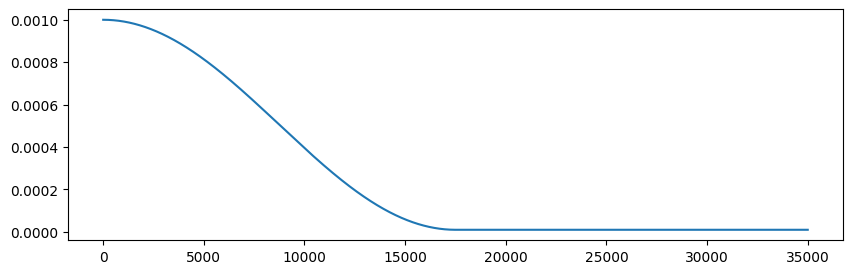

In [57]:
plt.figure(figsize=(10,3))
plt.plot(lrs)
plt.show()

In [3]:
import numpy as np

# def min_max_scale(waves, min_val=-1, max_val=1):
#     X_std = (waves.T - TOTAL_MIN_VAL) / (TOTAL_MAX_VAL - TOTAL_MIN_VAL)
#     X_scaled = X_std * (max_val - min_val) + min_val
#     return X_scaled.T


x = np.random.randint(low=0, high=10, size=(9, 9, 3))
x

array([[[6, 7, 4],
        [6, 5, 1],
        [3, 5, 2],
        [1, 1, 9],
        [7, 3, 4],
        [2, 2, 1],
        [4, 3, 3],
        [9, 2, 5],
        [3, 5, 7]],

       [[7, 3, 2],
        [2, 4, 0],
        [9, 0, 0],
        [1, 2, 1],
        [0, 4, 7],
        [5, 0, 8],
        [6, 6, 4],
        [7, 7, 9],
        [1, 8, 0]],

       [[4, 5, 6],
        [1, 0, 3],
        [1, 6, 9],
        [7, 3, 1],
        [6, 9, 6],
        [1, 9, 2],
        [3, 4, 2],
        [9, 9, 1],
        [3, 8, 9]],

       [[8, 1, 5],
        [1, 7, 1],
        [9, 1, 9],
        [8, 7, 2],
        [8, 3, 3],
        [1, 8, 1],
        [2, 3, 7],
        [4, 5, 1],
        [4, 1, 6]],

       [[7, 6, 7],
        [0, 4, 0],
        [8, 3, 5],
        [8, 3, 7],
        [7, 6, 4],
        [7, 1, 0],
        [0, 7, 9],
        [0, 4, 6],
        [0, 3, 3]],

       [[1, 2, 4],
        [6, 3, 2],
        [0, 2, 8],
        [4, 8, 3],
        [7, 3, 8],
        [4, 2, 1],
        [8, 8, 4],
  

In [16]:
X_std = (x - np.array([0, 0, 0])) / 10
X_scaled = X_std * (2) - 1

In [17]:
X_scaled

array([[[ 0.2,  0.4, -0.2],
        [ 0.2,  0. , -0.8],
        [-0.4,  0. , -0.6],
        [-0.8, -0.8,  0.8],
        [ 0.4, -0.4, -0.2],
        [-0.6, -0.6, -0.8],
        [-0.2, -0.4, -0.4],
        [ 0.8, -0.6,  0. ],
        [-0.4,  0. ,  0.4]],

       [[ 0.4, -0.4, -0.6],
        [-0.6, -0.2, -1. ],
        [ 0.8, -1. , -1. ],
        [-0.8, -0.6, -0.8],
        [-1. , -0.2,  0.4],
        [ 0. , -1. ,  0.6],
        [ 0.2,  0.2, -0.2],
        [ 0.4,  0.4,  0.8],
        [-0.8,  0.6, -1. ]],

       [[-0.2,  0. ,  0.2],
        [-0.8, -1. , -0.4],
        [-0.8,  0.2,  0.8],
        [ 0.4, -0.4, -0.8],
        [ 0.2,  0.8,  0.2],
        [-0.8,  0.8, -0.6],
        [-0.4, -0.2, -0.6],
        [ 0.8,  0.8, -0.8],
        [-0.4,  0.6,  0.8]],

       [[ 0.6, -0.8,  0. ],
        [-0.8,  0.4, -0.8],
        [ 0.8, -0.8,  0.8],
        [ 0.6,  0.4, -0.6],
        [ 0.6, -0.4, -0.4],
        [-0.8,  0.6, -0.8],
        [-0.6, -0.4,  0.4],
        [-0.2,  0. , -0.8],
        [-0.2,